In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'/home/ducanh/Financial Risk & Fraud Detection/Credit Card Fraud Detection/Datasets/CCFD/Combined_Data/combined_data.csv')

# Xử lý thời gian
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

In [4]:
print(df['trans_date_trans_time_numeric'].head())

0    1.592742e+09
1    1.592742e+09
2    1.592742e+09
3    1.592742e+09
4    1.592742e+09
Name: trans_date_trans_time_numeric, dtype: float64


## 1. Load dữ liệu và xử lý thời gian

             cc_num trans_date_trans_time   unix_time  delta_T  \
556736  60416207185   2019-01-01 12:47:15  1325422035      NaN   
558443  60416207185   2019-01-02 08:44:57  1325493897  71862.0   
558445  60416207185   2019-01-02 08:47:36  1325494056    159.0   
558601  60416207185   2019-01-02 12:38:14  1325507894  13838.0   
558626  60416207185   2019-01-02 13:10:46  1325509846   1952.0   
559854  60416207185   2019-01-03 13:56:35  1325598995  89149.0   
560056  60416207185   2019-01-03 17:05:10  1325610310  11315.0   
561186  60416207185   2019-01-04 13:59:55  1325685595  75285.0   
561746  60416207185   2019-01-04 21:17:22  1325711842  26247.0   
561992  60416207185   2019-01-05 00:42:24  1325724144  12302.0   

        delta_T_minutes  
556736              NaN  
558443      1197.700000  
558445         2.650000  
558601       230.633333  
558626        32.533333  
559854      1485.816667  
560056       188.583333  
561186      1254.750000  
561746       437.450000  
561992       

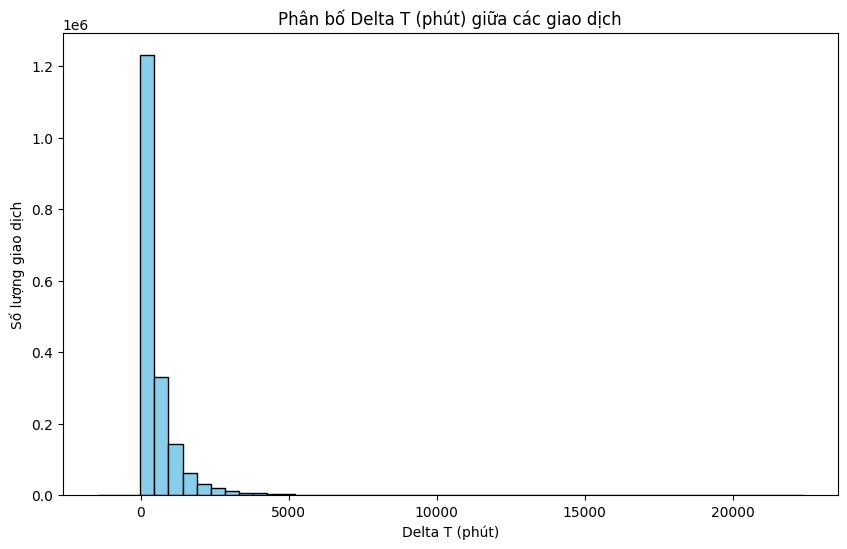

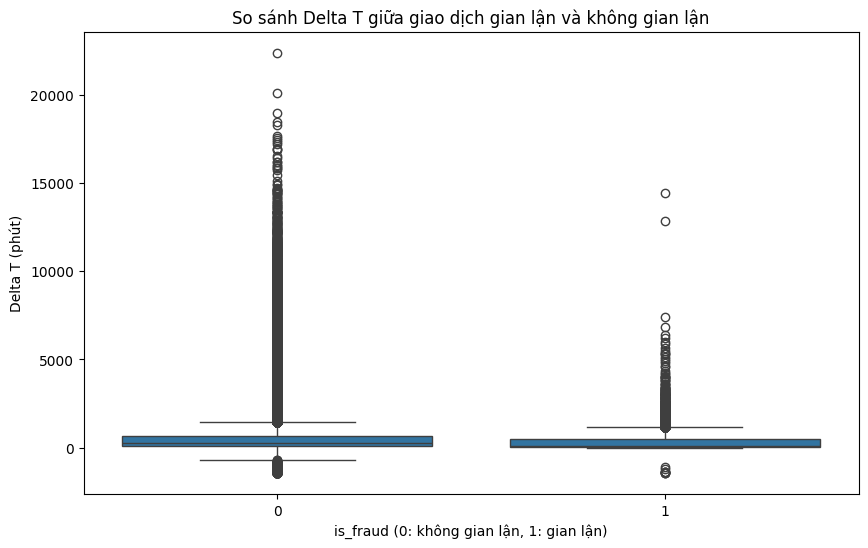

In [9]:
file_path = '/home/ducanh/Financial Risk & Fraud Detection/Credit Card Fraud Detection/Datasets/Combined_Data/combined_data.csv'
df = pd.read_csv(file_path)

# Chuyển đổi cột 'trans_date_trans_time' sang datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Sắp xếp dữ liệu theo 'cc_num' và 'trans_date_trans_time'
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])

# Tính toán delta T: hiệu số thời gian giữa các giao dịch (dựa trên 'unix_time') cho mỗi thẻ
df['delta_T'] = df.groupby('cc_num')['unix_time'].diff()
df['delta_T_minutes'] = df['delta_T'] / 60  # chuyển đổi từ giây sang phút

# Hiển thị vài dòng dữ liệu để kiểm tra
print(df[['cc_num', 'trans_date_trans_time', 'unix_time', 'delta_T', 'delta_T_minutes']].head(10))

# Vẽ histogram phân bố delta T (theo phút)
plt.figure(figsize=(10, 6))
plt.hist(df['delta_T_minutes'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Delta T (phút)')
plt.ylabel('Số lượng giao dịch')
plt.title('Phân bố Delta T (phút) giữa các giao dịch')
plt.show()

# Vẽ boxplot so sánh delta T giữa giao dịch không gian lận và gian lận
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='delta_T_minutes', data=df)
plt.xlabel('is_fraud (0: không gian lận, 1: gian lận)')
plt.ylabel('Delta T (phút)')
plt.title('So sánh Delta T giữa giao dịch gian lận và không gian lận')
plt.show()


## 2. Tính toán các đặc trưng thời gian và tuổi khách hàng


In [10]:
# Trích xuất giờ giao dịch và chuyển sang dạng số (timestamp)
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

# Tính delta_t theo từng người dùng (cc_num) và xử lý giá trị bất thường
df = df.sort_values(by=['cc_num', 'trans_date_trans_time_numeric'])
df['delta_t'] = df.groupby('cc_num')['trans_date_trans_time_numeric'].diff().fillna(0)
df['delta_t'] = df['delta_t'].clip(upper=1e5)
df['log_delta_t'] = np.log1p(df['delta_t'])

# Phân loại khoảng thời gian thành nhóm (đơn vị: giây)
bins = [-1, 60, 600, 3600, 21600, 86400, 1e6]
labels = ['<1min', '1-10min', '10-60min', '1-6h', '6-24h', '>1day']
df['delta_t_category'] = pd.cut(df['delta_t'], bins=bins, labels=labels)
df['delta_t_cat_num'] = df['delta_t_category'].cat.codes

# Xử lý biến 'dob' để tính tuổi khách hàng (dựa trên năm 2021)
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = 2021 - df['dob'].dt.year

# Phân nhóm tuổi dựa trên cust_age
df['cust_age_groups'] = df['cust_age'].apply(
    lambda x: 'below 10' if x < 10 else (
        '10-20' if 10 <= x < 20 else (
            '20-30' if 20 <= x < 30 else (
                '30-40' if 30 <= x < 40 else (
                    '40-50' if 40 <= x < 50 else (
                        '50-60' if 50 <= x < 60 else (
                            '60-70' if 60 <= x < 70 else (
                                '70-80' if 70 <= x < 80 else 'Above 80'))))))))


# Sử dụng pivot table để chuẩn hóa nhóm tuổi dựa trên giá trị trung bình của 'amt' theo nhãn is_fraud
age_pivot = pd.pivot_table(data=df, index='cust_age_groups', columns='is_fraud', values='amt', aggfunc=np.mean)
age_pivot.sort_values(by=1, ascending=True, inplace=True)
age_map = {k: v for k, v in zip(age_pivot.index.values, age_pivot.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_map)

/tmp/ipykernel_961507/1982252749.py:34: FutureWarning: The provided callable <function mean at 0x775d3932f0a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  age_pivot = pd.pivot_table(data=df, index='cust_age_groups', columns='is_fraud', values='amt', aggfunc=np.mean)


In [11]:
# 3. Xử lý các biến categorical khác
# -------------------------------
# Ánh xạ biến 'category' dựa trên giá trị trung bình của 'amt' trong giao dịch gian lận
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_map = {k: v for k, v in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_map)

# Ánh xạ biến 'job' dựa trên pivot table của 'amt' theo is_fraud
job_pivot = pd.pivot_table(data=df, index='job', columns='is_fraud', values='amt', aggfunc=np.mean)
job_map = {k: v for k, v in zip(job_pivot.index.values, job_pivot.reset_index().index.values)}
df['job'] = df['job'].map(job_map)

# Mã hóa biến 'gender' thành biến nhị phân
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')

# Mã hóa các biến định danh (merchant, first, last, street, city, state, zip)
cols_to_encode = ['merchant', 'first', 'last', 'street', 'city', 'state', 'zip']
for col in cols_to_encode:
    df[col + '_num'] = pd.factorize(df[col])[0]

# Chuyển đổi 'trans_hour' về kiểu số nguyên
df['trans_hour'] = df['trans_hour'].astype(int)

# -------------------------------
# 4. Phân tích và trực quan hóa ma trận tương quan
# -------------------------------
# Lấy danh sách các cột số
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'trans_date_trans_time' in numeric_features:
    numeric_features.remove('trans_date_trans_time')

# Tính ma trận tương quan
corr_matrix = df[numeric_features].corr()

# Tính hệ số tương quan của các feature với is_fraud
corr_with_label = corr_matrix['is_fraud'].drop('is_fraud')

# Sắp xếp các feature theo độ tương quan tuyệt đối tăng dần (thấp nhất)
lowest_corr = corr_with_label.abs().sort_values(ascending=True).reset_index()
lowest_corr.columns = ['Feature', 'Correlation_with_is_fraud']

# Sắp xếp các feature theo độ tương quan tuyệt đối giảm dần (cao nhất)
highest_corr = corr_with_label.abs().sort_values(ascending=False).reset_index()
highest_corr.columns = ['Feature', 'Correlation_with_is_fraud']

print("Các feature có độ tương quan thấp nhất với is_fraud:")
print(lowest_corr)
print("\nCác feature có độ tương quan cao nhất với is_fraud:")
print(highest_corr)

/tmp/ipykernel_961507/2021740078.py:9: FutureWarning: The provided callable <function mean at 0x775d3932f0a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  job_pivot = pd.pivot_table(data=df, index='job', columns='is_fraud', values='amt', aggfunc=np.mean)


Các feature có độ tương quan thấp nhất với is_fraud:
                          Feature  Correlation_with_is_fraud
0                        city_pop                   0.000325
1                      Unnamed: 0                   0.000524
2                      merch_long                   0.000999
3                            long                   0.001022
4                          cc_num                   0.001125
5                         zip_num                   0.001189
6                             job                   0.001388
7                       state_num                   0.001414
8                      street_num                   0.001452
9                    merchant_num                   0.001683
10                       city_num                   0.001876
11                       last_num                   0.002183
12                            zip                   0.002190
13                      merch_lat                   0.002778
14                      first_nu

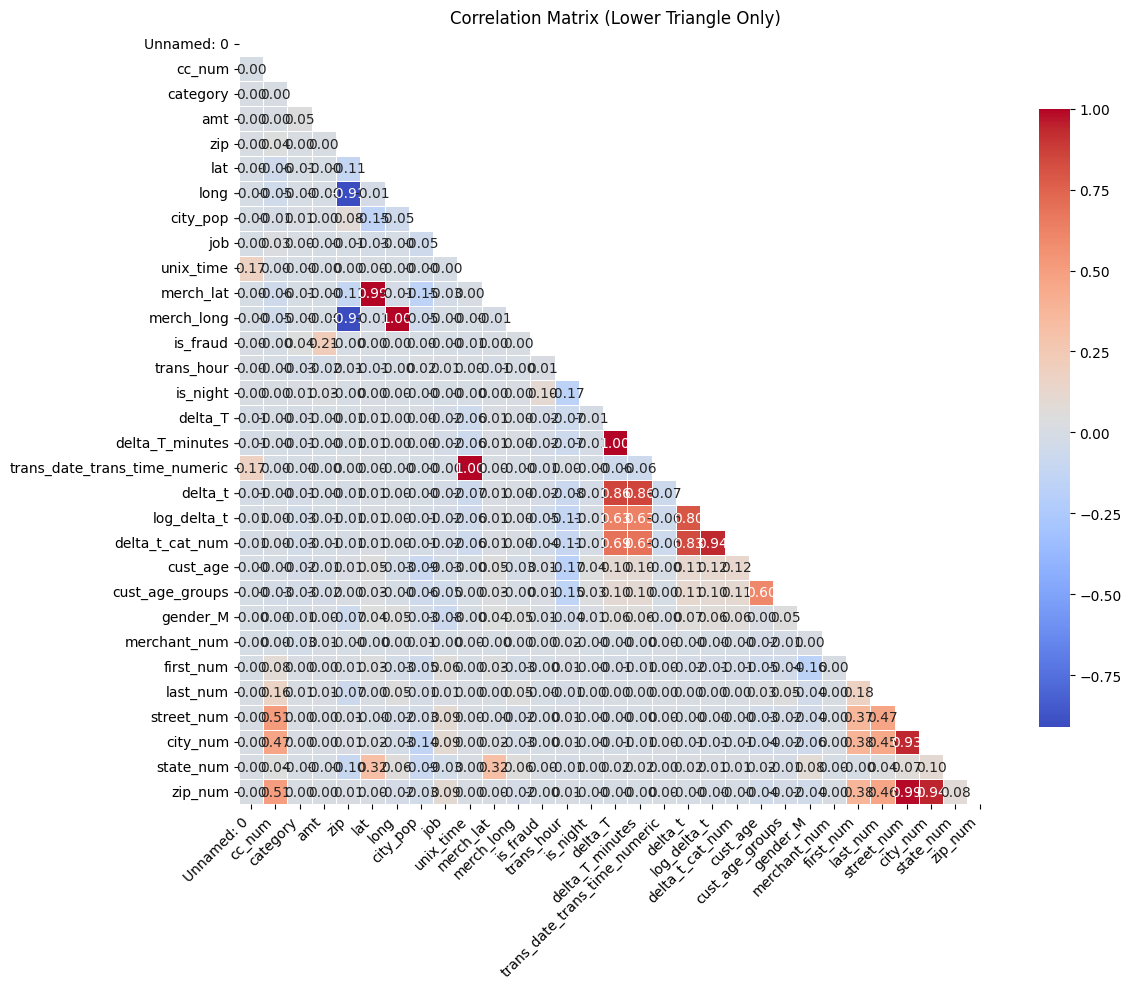

In [12]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix (Lower Triangle Only)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()